In [1]:
## Processing
import pandas as pd
from Bio import SeqIO

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

### Add a direct comparison of the prediction of this study and that obtained using existing tools

### Figure S5a and S5b difficult to see. Add Notches.

See `/figures/FigureS5.ipynb`.

### In their logistic regression model, the authors assign disorder to either PLDDT scores > 70 and coil prediction by DSSP or to a PLDDT<50. What is the probability of observing each case?

### What is the prevalence of highly-charged sequences in other proteomes (such as the human one)?

In [2]:
records = {}
with open('../../data/ref_proteomes/Homo_sapiens.fasta') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        records[record.id] = str(record.seq)

In [3]:
len(records)

114963

In [4]:
cr_hs = pd.read_csv('../../data/charged_regions/cr_homo_sapiens.csv', comment='#')
cr_hs.head(10)

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2
0,NP_000029.2,adenomatous,2843,1532,1580,NGNETESEQPKESNENQEKEAEKTIDSEKDLLDDSDDDDIEILEECIIS,49,0.217687,0.489796,0.079031,0.279810
1,NP_000030.1,apolipoprotein,267,91,152,TQEFWDNLEKETEGLRQEMSKDLEEVKAKVQPYLDDFQKKWQEEME...,62,0.029271,0.435484,0.051507,0.138749
2,NP_000032.1,apolipoprotein,317,224,267,AQAWGERLRARMEEMGSRTRDRLDEVKEQVAEVRAKLEEQAQQI,44,0.001196,0.431818,0.042555,0.114889
3,NP_000042.3,serine-protein,3056,9,53,ICCRQLEHDRATERKKEVEKFKRLIRDPETIKHLDRHSDSKQGKY,45,0.043556,0.488889,0.029856,0.069648
4,NP_000055.2,complement,1663,1488,1541,CTRFYHPEKEDGKLNKLCRDELCRCAEENCFIQKSDDKVTLEERLD...,54,0.006667,0.444444,0.034862,0.089707
5,NP_000059.3,voltage-dependent,2266,938,1040,RQGGSRESRSGSPRTGADGEHRRHRAHRRPGEEGPEDKAERRARHR...,103,0.049225,0.485437,0.144546,0.322122
6,NP_000060.2,voltage-dependent,1873,669,715,LTSAQKAKAEEKKRRKMSKGLPDKSEEEKSTMAKKLEQKPKGEGIPT,47,0.034816,0.468085,0.078154,0.201243
7,NP_000078.3,cGMP-gated,686,88,155,NNSSNKDQEPEEKKKKKKEKKSKSDDKNENKNDPEKKKKKKDKEKK...,68,0.024310,0.720588,0.089758,0.130267
8,NP_000086.2,cartilage,757,329,385,LVRNPDQRNTDEDKWGDACDNCRSQKNDDQKDTDQDGRGDACDDDI...,57,0.052632,0.473684,0.067017,0.172349
9,NP_000094.2,aromatase,503,235,280,KISWLYKKYEKSVKDLKDAIEVLIAEKRRRISTEEKLEECMDFATE,46,0.000000,0.478261,0.076768,0.178206


In [5]:
print('We extracted {} highly charged regions from the Human proteome'.format(len(cr_hs)))
print('About {:.1f}% of protein-coding genes encode at least one highly charged region.'.format(cr_hs['orf'].nunique() / len(records) * 100))

We extracted 29013 highly charged regions from the Human proteome
About 16.5% of protein-coding genes encode at least one highly charged region.


### Fig 2A: why is there a sudden jump in highly-charged and Random distributions at low/high fractions?

### Include an Uversky-like plot that κ vs FCR colored as helix/disordered as determined by AF

In [10]:
df = pd.read_csv("../../data/charged_regions/cr_trimmed_filtered_aflabel.csv")

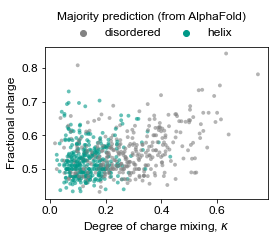

In [12]:
plt.figure(figsize=(4, 2.8))
sns.scatterplot(x = "kappa", y = "frac.charge", hue="label", data=df,
                palette=[cscheme["dis"], cscheme["helix"]], s=15, edgecolors=None, linewidth=0, alpha=0.6)
plt.xlabel("Degree of charge mixing, $\kappa$")
plt.ylabel("Fractional charge")
plt.legend(title="Majority prediction (from AlphaFold)",
           bbox_to_anchor=(0.95, 1.3), ncol=2, frameon=False, columnspacing=1)
#plt.savefig('./plots/FigureS2B-alt.png', dpi=300, bbox_inches='tight')
plt.show()